# Visualising IL34-CSF1R with backgrounds as an example.

INPUT:
 * /Volumes/GML001-Q1851/Brad/skin_analysis/skin_lrs.h5ad
 * /Volumes/GML001-Q1851/Brad/skin_analysis/naiive_bg.pkl
 
OUTPUT:
 * plots/X3_skin_analysis/IL34_CSF1R*
 
## Environment setup

In [1]:
# TODO change this to your directory
work_dir = '/Users/uqbbalde/Desktop/Uni_Studies/projects/stlearn_manuscript/mainfigCCI_newCCISupps/'

import os
os.chdir(work_dir)

import warnings
warnings.filterwarnings("ignore")

import copy
import matplotlib
import numpy as np
import pandas as pd
import scanpy as sc
import stlearn as st
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

import scripts.X3_skin_analysis.helpers as fhs
import scripts.utils.load_data.simple_pickle as spl
import scripts.utils.visualisation.helpers as vhs
import scripts.utils.visualisation.quick_plots as qpl
qpl.setUp(font_size=20)

data_dir = '/Volumes/GML001-Q1851/Brad/skin_analysis/'
out_plots = 'plots/X3_skin_analysis/'
out_dir = data_dir

## Load the data

In [2]:
data = sc.read_h5ad(data_dir+'skin_lrs.h5ad')
background_naiive = spl.loadPickle(data_dir+'naiive_bg.pkl')['background']

## Getting the stats from the naiive bg

In [20]:
pvals_naiive, padjs_naiive = fhs.get_stats(data, background_naiive)

#### Adding to the summary df #####
summ_df = copy.deepcopy( data.uns['lr_summary'] )

n_spots_sig = (data.obsm['p_vals']<.05).sum(axis=0)
summ_df['n_spots_sig_pval<.05'] = n_spots_sig

n_spots_sig_constBg = (padjs_naiive<.05).sum(axis=0)
summ_df['n_spots_sig_constBg'] = n_spots_sig_constBg

n_spots_sig_constBg = (pvals_naiive<.05).sum(axis=0)
summ_df['n_spots_sig_constBg_pval<.05'] = n_spots_sig_constBg

###### Adding together the results from the constant background #####
group_df = data.uns['lrfeatures']

group_df = pd.concat((group_df, summ_df), axis=1)

## Plotting diagnostic scatters

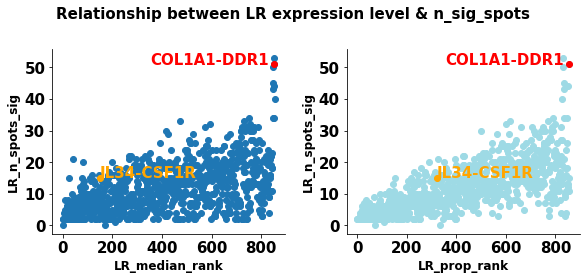

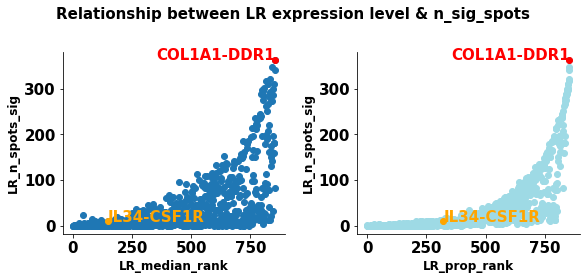

In [21]:
#### Setting up the plotting ####
fsize1, fsize2 = 15, 12
matplotlib.rcParams.update({'font.size': fsize1, 'font.weight': 'bold',
                          'figure.titlesize': 15, 'figure.titleweight': 'bold'})
fp = {'weight' : 'bold', 'size' : fsize2}
height = 4

lrs = ['IL34_CSF1R', 'COL1A1_DDR1']
lr_colors = ['orange', 'red']
adj = [0, -500]

##### Plotting the relationship between LR expression level & n_sig_spots ######
y = summ_df.loc[group_df.index.values, 'n_spots_sig_pval<.05'].values
fhs.diagnostic_scatters(y, group_df, height, fp, lrs, lr_colors, adj,
                        out_plots, f'stlearnBg_LRExprBias_scatter.pdf')

##### Repeating for n-sig-spots for constant background  ######
y = summ_df.loc[group_df.index.values, 'n_spots_sig_constBg_pval<.05'].values
fhs.diagnostic_scatters(y, group_df, height, fp, lrs, lr_colors, adj,
                        out_plots, f'naiiveBg_LRExprBias_scatter.pdf')

## Visualising the spots for this LR

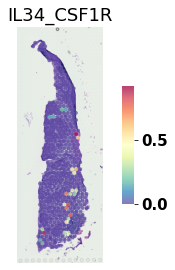

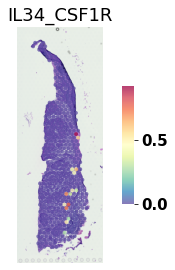

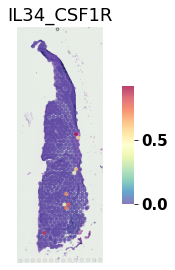

In [22]:
best_lr = 'IL34_CSF1R'
best_lr_index = np.where(summ_df.index.values==best_lr)[0][0]

sig_spots = data.obsm['p_vals'][:,best_lr_index]<.05
data.obsm['lr_sig_scores'] = data.obsm['lr_scores'].copy()
data.obsm['lr_sig_scores'][sig_spots==False,best_lr_index] = 0

show=True
end='.pdf'
size=15
a = .75
st.pl.lr_result_plot(data, use_result='lr_scores', use_lr=best_lr,
                     size=size, cell_alpha=a)
vhs.dealWithPlot(True, show, True, out_plots,
                 f'{best_lr}_lrscores_spatial{end}', 300)

st.pl.lr_result_plot(data, use_result='lr_sig_scores', use_lr=best_lr,
                     size=size, cell_alpha=a)
vhs.dealWithPlot(True, show, True, out_plots,
                 f'{best_lr}_lr_sig_scores_spatial{end}', 300)

############ Now for the naiive background #############
sig_spots = pvals_naiive[:,best_lr_index]<.05
data.obsm['lr_sig_scores'] = data.obsm['lr_scores'].copy()
data.obsm['lr_sig_scores'][sig_spots==False,best_lr_index] = 0

st.pl.lr_result_plot(data, use_result='lr_sig_scores', use_lr=best_lr,
                     size=size, cell_alpha=a)
vhs.dealWithPlot(True, show, True, out_plots,
                 f'{best_lr}_naiive_lr_sig_scores_spatial{end}', 300)

## Looking at the backgrounds

... storing 'examples' as categorical


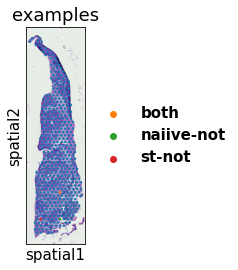

0.0427 0.0697
0.0427 0.0697


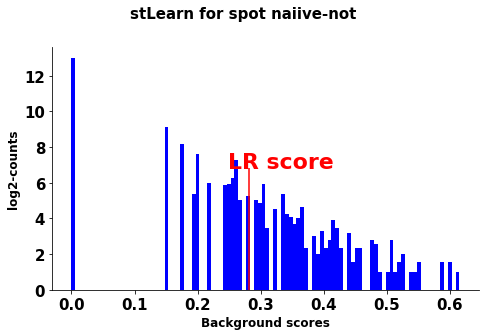

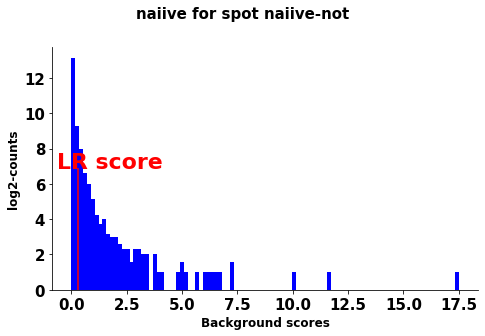

0.0664 0.0411
0.0664 0.0411


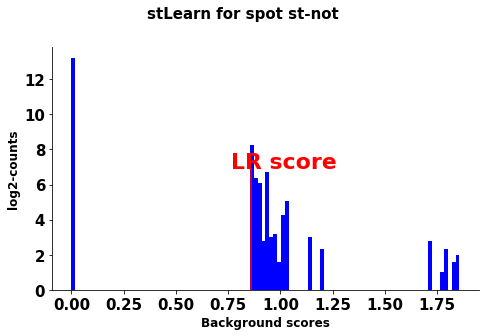

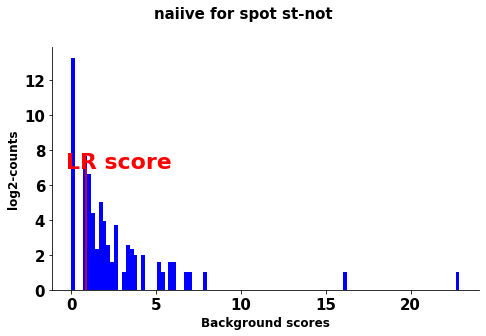

0.0316 0.0432
0.0316 0.0432


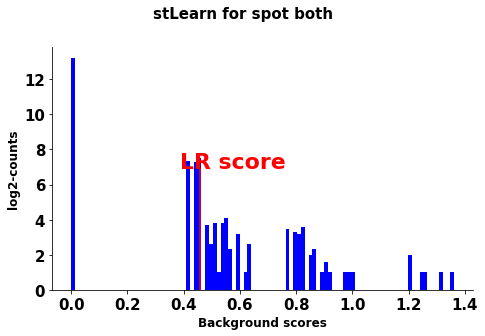

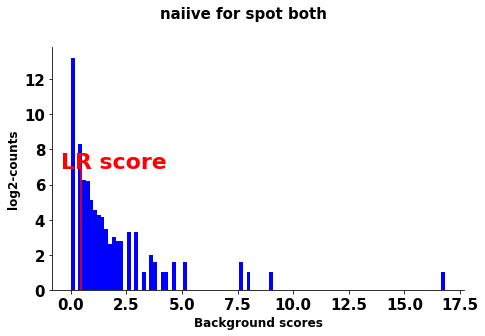

In [23]:
#### Setting up the plotting ####
fsize1, fsize2 = 15, 12
matplotlib.rcParams.update({'font.size': fsize1, 'font.weight': 'bold',
                          'figure.titlesize': 15, 'figure.titleweight': 'bold'})
fp = {'weight' : 'bold', 'size' : fsize2}

lr_ = best_lr
lr_summary = summ_df

lr_index = np.where( lr_summary.index.values==lr_ )[0][0]
lr_ = lr_summary.index.values[lr_index]
background = data.uns['lrs_to_bg'][lr_]
spot_indices = data.uns['lr_spot_indices'][lr_]

pvals = data.obsm['p_vals'][spot_indices, lr_index]
pvals_naiive = pvals_naiive[spot_indices, lr_index]
lr_scores = data.obsm['lr_scores'][spot_indices,lr_index]
sig_indices_bg = np.where(pvals < .05)[0]
nonsig_indices_bg = np.where(pvals > .05)[0]

########### Choosing spots to plot background for !! ###########################
max_index = np.argmax(lr_scores)
stlearn_not_sig_naiive_sig = np.where(np.logical_and(pvals>.05,
                                                     pvals_naiive<.05))[0][0]
stlearn_sig_naiive_not_sig = np.where(np.logical_and(pvals<.05,
                                                    pvals_naiive>.05))[0][2]
both_sig = np.where(np.logical_and(pvals<.05, pvals_naiive<.05))[0][1]
indices = [stlearn_sig_naiive_not_sig, stlearn_not_sig_naiive_sig, both_sig]
index_names = {indices[0]: 'naiive-not', indices[1]: 'st-not', indices[2]: 'both'
               }

# Visualising the selected spots #
indices2 = spot_indices[indices]
index_names2 = {indices2[0]: 'naiive-not', indices2[1]: 'st-not', indices2[2]: 'both'
               }
spot_labels = ['' if i not in indices2 else index_names2[i]
               for i in range(len(data))]
data.obs['examples'] = spot_labels
sc.pl.spatial(data, color='examples', show=False)
vhs.dealWithPlot(True, show, True, out_plots,
                 f'{best_lr}_eg-spots_spatial{end}', 300)

# Looking at the background distribution #
names = ['stLearn', 'naiive']
sig_indices = [sig_indices_bg, np.where(pvals_naiive<.05)[0]]
for i, index in enumerate(indices):
    lr_score = lr_scores[index]
    bg_st = background[index,:]
    bg_naiive = background_naiive[spot_indices[index],:]
    # Sanity check am indexing these correctly, should match #
    print(sum(bg_st>=lr_score)/len(bg_st),
          sum(bg_naiive>=lr_score)/len(bg_naiive))
    print(pvals[index], pvals_naiive[index])
    bgs = [bg_st, bg_naiive]
    for j, bg_ in enumerate(bgs):
        sig_indices_ = sig_indices[j]
        fig, ax_ = qpl.distrib(bg_, bins=100, log=True, figsize=(7,4.8),
                               x_label='Background scores', show=False,
                               logbase=2)
        ax_.spines['top'].set_visible(False)
        ax_.spines['right'].set_visible(False)
        x_min, x_max = ax_.get_xlim()
        y_min, y_max = ax_.get_ylim()
        ax_.vlines(lr_score, 0, y_max*.5, colors='r')
        #pref = 'sig' if index in sig_indices_ else 'non-sig'
        pref = ''
        ax_.text(lr_score-(.05*x_max), y_max*.5, pref+'LR score', c='r',
                 fontsize= 22)
        fig.suptitle(f'{names[j]} for spot {index_names[index]}')
        vhs.dealWithPlot(True, True, True, out_plots,
                     f'{lr_}_{index_names[index]}_{names[j]}_skin.pdf', dpi=300)